In [1]:
import pandas as pd
import geopandas as gpd
import folium
import os, shutil
from glob import glob
import numpy as np
import pyproj
from shapely import geometry
import matplotlib.pyplot as plt
from pathlib import Path
import requests
from bs4 import BeautifulSoup

%matplotlib inline

In [2]:
coords = [[37.937489, -121.154154], [38.015273, -120.854981], [37.836765, -120.823077]]
coords = [geometry.Point(y, x) for x, y in coords]
multipoints = geometry.MultiPoint(coords)
bounds = multipoints.envelope
if not os.path.exists("data"):
    os.makedirs('data/')
gpd.GeoSeries(bounds).to_file('data/area_of_study_bounds.gpkg', 'GPKG')
str(bounds)

'POLYGON ((-121.154154 37.836765, -120.823077 37.836765, -120.823077 38.015273, -121.154154 38.015273, -121.154154 37.836765))'

In [3]:
bounds_out = gpd.read_file('data/area_of_study_bounds.gpkg')

In [4]:
bounds = gpd.read_file('data/area_of_study_bounds.gpkg')

print(bounds.geometry[0])

if not os.path.exists("data/external/Landsat8"):
    os.makedirs("data/external/Landsat8")
WRS_PATH = './data/external/Landsat8/WRS2_descending_0.zip'
LANDSAT_PATH = os.path.dirname(WRS_PATH)

!wget -P {LANDSAT_PATH} https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip

shutil.unpack_archive(WRS_PATH, os.path.join(LANDSAT_PATH, 'wrs2'))

POLYGON ((-121.154154 37.836765, -120.823077 37.836765, -120.823077 38.015273, -121.154154 38.015273, -121.154154 37.836765))
--2019-10-19 15:56:38--  https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip
Resolving prd-wret.s3-us-west-2.amazonaws.com (prd-wret.s3-us-west-2.amazonaws.com)... 52.218.235.17
Connecting to prd-wret.s3-us-west-2.amazonaws.com (prd-wret.s3-us-west-2.amazonaws.com)|52.218.235.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5268095 (5.0M) [application/zip]
Saving to: ‘./data/external/Landsat8/WRS2_descending_0.zip.1’

WRS2_descending_0.z 100%[===================>]   5.02M  4.00MB/s    in 1.3s    

2019-10-19 15:56:40 (4.00 MB/s) - ‘./data/external/Landsat8/WRS2_descending_0.zip.1’ saved [5268095/5268095]



In [5]:
wrs = gpd.GeoDataFrame.from_file('./data/external/Landsat8/wrs2/WRS2_descending.shp')

wrs.head()

,AREA,PERIMETER,PR_,PR_ID,RINGS_OK,RINGS_NOK,PATH,ROW,MODE,SEQUENCE,WRSPR,PR,ACQDayL7,ACQDayL8,geometry
0,15.74326,26.98611,1.0,1.0,1,0,13,1,D,2233,013001,013001,1,9,"POLYGON ((-10.80341 80.98880, -8.97407 80.3420..."
1,14.55366,25.84254,2.0,2.0,1,0,13,2,D,2234,013002,013002,1,9,"POLYGON ((-29.24250 80.18681, -29.29593 80.198..."
2,13.37247,24.20303,3.0,3.0,1,0,13,3,D,2235,013003,013003,1,9,"POLYGON ((-24.04206 79.12261, -23.78294 79.063..."
3,12.26691,22.40265,4.0,4.0,1,0,13,4,D,2236,013004,013004,1,9,"POLYGON ((-36.66813 77.46094, -40.05219 78.098..."
4,11.26511,20.64284,5.0,5.0,1,0,13,5,D,2237,013005,013005,1,9,"POLYGON ((-44.11210 76.93656, -44.12470 76.938..."


In [6]:
wrs_intersection = wrs[wrs.intersects(bounds_out.geometry[0])]

paths, rows = wrs_intersection['PATH'].values, wrs_intersection['ROW'].values

print(sum(wrs.intersects(bounds_out.geometry[0])))
paths, rows

3


(array([43, 44, 44]), array([34, 33, 34]))

In [7]:
# Get the center of the map
xy = np.asarray(bounds.centroid[0].xy).squeeze()
center = list(xy[::-1])

# Select a zoom
zoom = 6

# Create the most basic OSM folium map
m = folium.Map(location=center, zoom_start=zoom, control_scale=True)

# Add the bounds GeoDataFrame in red
m.add_child(folium.GeoJson(bounds.__geo_interface__, name='Area of Study', 
                           style_function=lambda x: {'color': 'red', 'alpha': 0}))

# Iterate through each Polygon of paths and rows intersecting the area
for i, row in wrs_intersection.iterrows():
    # Create a string for the name containing the path and row of this Polygon
    name = 'path: %03d, row: %03d' % (row.PATH, row.ROW)
    # Create the folium geometry of this Polygon 
    g = folium.GeoJson(row.geometry.__geo_interface__, name=name)
    # Add a folium Popup object with the name string
    g.add_child(folium.Popup(name))
    # Add the object to the map
    g.add_to(m)

folium.LayerControl().add_to(m)
if not os.path.exists("images/10"):
    os.makedirs("images/10")
m.save('./images/10/wrs.html')
m

In [8]:
for i, (path, row) in enumerate(zip(paths, rows)):
    print('Image', i+1, ' - path:', path, 'row:', row)

Image 1  - path: 43 row: 34
Image 2  - path: 44 row: 33
Image 3  - path: 44 row: 34


In [9]:
!wget -P {LANDSAT_PATH} http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz
SCENE_LIST_PATH = LANDSAT_PATH + "/scene_list.gz"

--2019-10-19 15:56:42--  http://landsat-pds.s3.amazonaws.com/c1/L8/scene_list.gz
Resolving landsat-pds.s3.amazonaws.com (landsat-pds.s3.amazonaws.com)... 52.218.192.82
Connecting to landsat-pds.s3.amazonaws.com (landsat-pds.s3.amazonaws.com)|52.218.192.82|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72340305 (69M) [binary/octet-stream]
Saving to: ‘./data/external/Landsat8/scene_list.gz.1’

scene_list.gz.1     100%[===================>]  68.99M  19.2MB/s    in 4.9s    

2019-10-19 15:56:48 (14.0 MB/s) - ‘./data/external/Landsat8/scene_list.gz.1’ saved [72340305/72340305]



In [10]:
s3_scenes = pd.read_csv(SCENE_LIST_PATH, compression='gzip')

In [11]:
s3_scenes.head(3)

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
0,LC08_L1TP_149039_20170411_20170415_01_T1,LC81490392017101LGN00,2017-04-11 05:36:29.349932,0.00,L1TP,149,39,29.22165,72.41205,31.34742,74.84666,https://s3-us-west-2.amazonaws.com/landsat-pds...
1,LC08_L1TP_012001_20170411_20170415_01_T1,LC80120012017101LGN00,2017-04-11 15:14:40.001201,0.15,L1TP,12,1,79.51504,-22.06995,81.90314,-7.44339,https://s3-us-west-2.amazonaws.com/landsat-pds...
2,LC08_L1TP_012002_20170411_20170415_01_T1,LC80120022017101LGN00,2017-04-11 15:15:03.871058,0.38,L1TP,12,2,78.74882,-29.24387,81.14549,-15.04330,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [12]:
from datetime import datetime

In [13]:
# Empty list to add the images
bulk_list = []

# Iterate through paths and rows
for path, row in zip(paths, rows):

    print('Path:',path, 'Row:', row)
    
    datetime_object = datetime.strptime(s3_scenes.acquisitionDate[0], '%Y-%m-%d %H:%M:%S.%f')
    
    print(s3_scenes.acquisitionDate[0], type(s3_scenes.acquisitionDate[0]), datetime_object, type(datetime_object))

    # Filter the Landsat Amazon S3 table for images matching path, row, cloudcover and processing state.
    scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) & 
                       (s3_scenes.cloudCover <= 5) & 
                       (~s3_scenes.productId.str.contains('_T2')) &
                       (~s3_scenes.productId.str.contains('_RT'))]
    print(' Found {} images\n'.format(len(scenes)))

    # If any scenes exists, select the one that have the minimum cloudCover.
    if len(scenes):
        scene = scenes.sort_values('acquisitionDate').iloc[-1]

    # Add the selected scene to the bulk download list.
    bulk_list.append(scene)

Path: 43 Row: 34
2017-04-11 05:36:29.349932 <class 'str'> 2017-04-11 05:36:29.349932 <class 'datetime.datetime'>
 Found 86 images

Path: 44 Row: 33
2017-04-11 05:36:29.349932 <class 'str'> 2017-04-11 05:36:29.349932 <class 'datetime.datetime'>
 Found 84 images

Path: 44 Row: 34
2017-04-11 05:36:29.349932 <class 'str'> 2017-04-11 05:36:29.349932 <class 'datetime.datetime'>
 Found 42 images



In [14]:
bulk_frame = pd.concat(bulk_list, 1).T
bulk_frame

,productId,entityId,acquisitionDate,cloudCover,processingLevel,path,row,min_lat,min_lon,max_lat,max_lon,download_url
1736355,LC08_L1TP_043034_20191003_20191018_01_T1,LC80430342019276LGN00,2019-10-03 18:40:15.717324,0.08,L1TP,43,34,36.393,-121.867,38.5339,-119.33,https://s3-us-west-2.amazonaws.com/landsat-pds...
1734333,LC08_L1TP_044033_20190924_20191017_01_T1,LC80440332019267LGN00,2019-09-24 18:46:00.436206,0.01,L1TP,44,33,37.8239,-122.995,39.9589,-120.385,https://s3-us-west-2.amazonaws.com/landsat-pds...
1734037,LC08_L1TP_044034_20190924_20191017_01_T1,LC80440342019267LGN00,2019-09-24 18:46:24.331481,0.03,L1TP,44,34,36.3974,-123.412,38.5255,-120.835,https://s3-us-west-2.amazonaws.com/landsat-pds...


In [15]:
# Import requests and beautiful soup
import requests
from bs4 import BeautifulSoup

# For each row
for i, row in bulk_frame.iterrows():

    # Print some the product ID
    print('\n', 'EntityId:', row.productId, '\n')
    print(' Checking content: ', '\n')

    # Request the html text of the download_url from the amazon server. 
    # download_url example: https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/index.html
    response = requests.get(row.download_url)

    # If the response status code is fine (200)
    if response.status_code == 200:

        # Import the html to beautiful soup
        html = BeautifulSoup(response.content, 'html.parser')

        # Create the dir where we will put this image files.
        entity_dir = os.path.join(LANDSAT_PATH, row.productId)
        os.makedirs(entity_dir, exist_ok=True)

        # Second loop: for each band of this image that we find using the html <li> tag
        for li in html.find_all('li'):

            # Get the href tag
            file = li.find_next('a').get('href')

            print('  Downloading: {}'.format(file))

            # Download the files
            # code from: https://stackoverflow.com/a/18043472/5361345

            response = requests.get(row.download_url.replace('index.html', file), stream=True)

            with open(os.path.join(entity_dir, file), 'wb') as output:
                shutil.copyfileobj(response.raw, output)
            del response


 EntityId: LC08_L1TP_043034_20191003_20191018_01_T1 

 Checking content:  

  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B9.TIF
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_BQA.TIF
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B4_wrk.IMD
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_ANG.txt
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B1_wrk.IMD
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B5.TIF.ovr
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B2.TIF
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B2.TIF.ovr
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B10.TIF.ovr
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B9.TIF.ovr
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B3.TIF.ovr
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B6.TIF
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B7.TIF.ovr
  Downloading: LC08_L1TP_043034_20191003_20191018_01_T1_B1.TIF.ovr
  

KeyboardInterrupt: 

In [16]:
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import cartopy.crs as ccrs

In [17]:
xmin, xmax, ymin, ymax = [], [], [], []

for image_path in glob(os.path.join(LANDSAT_PATH, '*/*B10.TIF')):
    with rasterio.open(image_path) as src_raster:
        xmin.append(src_raster.bounds.left)
        xmax.append(src_raster.bounds.right)        
        ymin.append(src_raster.bounds.bottom)        
        ymax.append(src_raster.bounds.top)        

[[601485.0, 464085.0, 500385.0], [829215.0, 694215.0, 730215.0], [4033785.0, 4030185.0, 4189485.0], [4265715.0, 4264215.0, 4423215.0]]
[464085.0, 829215.0, 4030185.0, 4423215.0]
[601485.0, 829215.0, 4033785.0, 4265715.0]
<class 'numpy.ndarray'> (7731, 7591) uint16


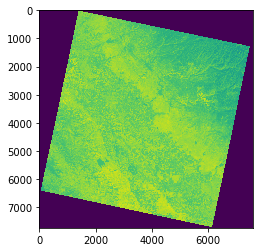

[464085.0, 694215.0, 4030185.0, 4264215.0]
<class 'numpy.ndarray'> (7801, 7671) uint16


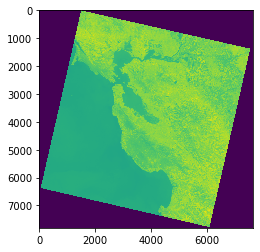

[500385.0, 730215.0, 4189485.0, 4423215.0]
<class 'numpy.ndarray'> (7791, 7661) uint16


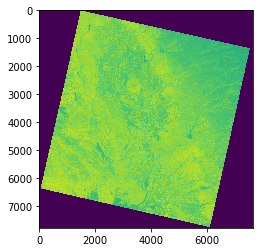

<class 'numpy.ndarray'> (14411, 13388) uint16


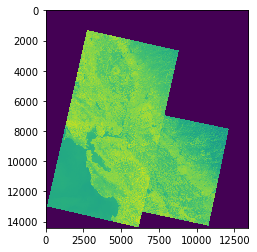

In [18]:
extent_all = [[], [], [], []]

height_mod = 1
width_mod = 1

for image_path in glob(os.path.join(LANDSAT_PATH, '*/*B10.TIF')):

    with rasterio.open(image_path) as src_raster:
        extent = [src_raster.bounds[i] for i in [0, 2, 1, 3]]
        for i, ex in enumerate(extent):
            extent_all[i].append(extent[i])
        height_mod = src_raster.read(1).shape[0] / (extent[3] - extent[2])
        width_mod = src_raster.read(1).shape[1] / (extent[1] - extent[0])

print(extent_all)

extent_all[0] = np.min(extent_all[0])
extent_all[1] = np.max(extent_all[1])
extent_all[2] = np.min(extent_all[2])
extent_all[3] = np.max(extent_all[3])

print(extent_all)

dst = np.zeros((int((extent_all[3] - extent_all[2]) * height_mod * 1.1),
                int((extent_all[1] - extent_all[0]) * width_mod * 1.1)), np.uint16)

for image_path in glob(os.path.join(LANDSAT_PATH, '*/*B10.TIF')):

    with rasterio.open(image_path) as src_raster:
        extent = [src_raster.bounds[i] for i in [0, 2, 1, 3]]
        
        print(extent)
        
        src = src_raster.read(1)
        
        plt.imshow(src)
        print(type(src), src.shape, src.dtype)
        plt.show()
        
        startx = dst.shape[0] - int((extent[2] - extent_all[2]) * height_mod) - src.shape[0]
        starty = int((extent[0] - extent_all[0]) * width_mod)
        dst[startx:startx+src.shape[0], starty:starty+src.shape[1]] = src + dst[startx:startx+src.shape[0], starty:starty+src.shape[1]] * (src == 0)


plt.imshow(dst)
print(type(dst), dst.shape, dst.dtype)
plt.show()

In [19]:
s3_scenes = pd.read_csv(SCENE_LIST_PATH, compression='gzip')

to_datetime = lambda x: datetime.strptime(x.split(".")[0], '%Y-%m-%d %H:%M:%S')

s3_scenes['acquisitionDate'] = s3_scenes['acquisitionDate'].apply(to_datetime)

In [20]:
def get_image(coords, date_time, band):
    coords = [geometry.Point(y, x) for x, y in coords]
    multipoints = geometry.MultiPoint(coords)
    bounds = multipoints.envelope
    
    WRS_PATH = './data/external/Landsat8/WRS2_descending_0.zip'
    LANDSAT_PATH = os.path.dirname(WRS_PATH)
    wrs = gpd.GeoDataFrame.from_file('./data/external/Landsat8/wrs2/WRS2_descending.shp')
    wrs_intersection = wrs[wrs.intersects(bounds)]

    paths, rows = wrs_intersection['PATH'].values, wrs_intersection['ROW'].values
    
    print(len(wrs_intersection))
    
    bulk_list = []

    # Iterate through paths and rows
    for path, row in zip(paths, rows):
        scenes = s3_scenes[(s3_scenes.path == path) & (s3_scenes.row == row) & 
                           (s3_scenes.cloudCover <= 5) & 
                           (s3_scenes.acquisitionDate <= date_time) & 
                           (~s3_scenes.productId.str.contains('_T2')) &
                           (~s3_scenes.productId.str.contains('_RT'))]

        if len(scenes):
            scene = scenes.sort_values('acquisitionDate').iloc[-1]

        # Add the selected scene to the bulk download list.
        bulk_list.append(scene)
        
    files = []
    file_coords = []
    
    bulk_frame = pd.concat(bulk_list, 1).T
        
    for i, row in bulk_frame.iterrows():

        # Print some the product ID
        print('\n', 'EntityId:', row.productId, '\n')
        print(' Checking content: ', '\n')

        # Request the html text of the download_url from the amazon server. 
        # download_url example: https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/index.html
        response = requests.get(row.download_url)

        # If the response status code is fine (200)
        if response.status_code == 200:

            # Import the html to beautiful soup
            html = BeautifulSoup(response.content, 'html.parser')

            # Create the dir where we will put this image files.
            entity_dir = os.path.join(LANDSAT_PATH, row.productId)
            os.makedirs(entity_dir, exist_ok=True)

            # Second loop: for each band of this image that we find using the html <li> tag
            for li in html.find_all('li'):

                # Get the href tag
                file = li.find_next('a').get('href')
                
                if not file.endswith("B" + str(band) + ".TIF"):
                    continue
                
                files.append(Path(entity_dir) / file)
                file_coords.append([row.min_lon, row.max_lon, row.min_lat, row.max_lat])

                print('  Downloading: {}'.format(file))
                if file in os.listdir(entity_dir):
                    continue

                # Download the files
                # code from: https://stackoverflow.com/a/18043472/5361345

                response = requests.get(row.download_url.replace('index.html', file), stream=True)

                with open(os.path.join(entity_dir, file), 'wb') as output:
                    shutil.copyfileobj(response.raw, output)
                del response
    
    extent_all = [[], [], [], []]

    height_mod = 1
    width_mod = 1
    
    lat_mod = 1
    lon_mod = 1

    for image_path, file_coord in zip(files, file_coords):
        image_path = str(image_path)

        with rasterio.open(image_path) as src_raster:
            extent = [src_raster.bounds[i] for i in [0, 2, 1, 3]]
            for i, ex in enumerate(extent):
                extent_all[i].append(extent[i])
            height_mod = src_raster.read(1).shape[0] / (extent[3] - extent[2])
            width_mod = src_raster.read(1).shape[1] / (extent[1] - extent[0])
            lat_mod = src_raster.read(1).shape[0] / (file_coord[3] - file_coord[2])
            lon_mod = src_raster.read(1).shape[1] / (file_coord[1] - file_coord[0])

    extent_all[0] = np.min(extent_all[0])
    extent_all[1] = np.max(extent_all[1])
    extent_all[2] = np.min(extent_all[2])
    extent_all[3] = np.max(extent_all[3])
    
    coords_all = [0, 0, 0, 0]
    
    coords_all[0] = np.min([coord[0] for coord in file_coords])
    coords_all[1] = np.max([coord[1] for coord in file_coords])
    coords_all[2] = np.min([coord[2] for coord in file_coords])
    coords_all[3] = np.max([coord[3] for coord in file_coords])
    
    bounds = bounds.bounds
    bounds = [bounds[i] for i in [0, 2, 1, 3]]
    print(bounds)
#     bounds = [np.min(bounds[1::2]), np.max(bounds[1::2]), np.min(bounds[::2]), np.max(bounds[::2])]

    dst = np.zeros((int((extent_all[3] - extent_all[2]) * height_mod * 1.1),
                    int((extent_all[1] - extent_all[0]) * width_mod * 1.1)), np.uint16)

    for image_path, f_coords in zip(files, file_coords):
        image_path = str(image_path)

        with rasterio.open(image_path) as src_raster:
            extent = [src_raster.bounds[i] for i in [0, 2, 1, 3]]

            src = src_raster.read(1)

            startx = dst.shape[0] - int((extent[2] - extent_all[2]) * height_mod) - src.shape[0]
            starty = int((extent[0] - extent_all[0]) * width_mod)
            
            dst[startx:startx+src.shape[0], starty:starty+src.shape[1]] = \
                    src + dst[startx:startx+src.shape[0], starty:starty+src.shape[1]] * (src == 0)
    
    boxx0 = dst.shape[0] - int((bounds[3] - coords_all[2]) * lat_mod)
    boxy0 = int((bounds[0] - coords_all[0]) * lon_mod)

    boxx1 = dst.shape[0] - int((bounds[2] - coords_all[2]) * lat_mod)
    boxy1 = int((bounds[1] - coords_all[0]) * lon_mod)

    return dst[boxx0:boxx1, boxy0:boxy1]

2

 EntityId: LC08_L1TP_044033_20190924_20191017_01_T1 

 Checking content:  

  Downloading: LC08_L1TP_044033_20190924_20191017_01_T1_B5.TIF

 EntityId: LC08_L1TP_044034_20190924_20191017_01_T1 

 Checking content:  

  Downloading: LC08_L1TP_044034_20190924_20191017_01_T1_B5.TIF
[-121.638645, -121.527724, 38.022724, 38.097357]
2

 EntityId: LC08_L1TP_044033_20190924_20191017_01_T1 

 Checking content:  

  Downloading: LC08_L1TP_044033_20190924_20191017_01_T1_B4.TIF

 EntityId: LC08_L1TP_044034_20190924_20191017_01_T1 

 Checking content:  

  Downloading: LC08_L1TP_044034_20190924_20191017_01_T1_B4.TIF
[-121.638645, -121.527724, 38.022724, 38.097357]
<class 'numpy.ndarray'> (273, 330) float64 0.0 1.0 0.47570947175895206


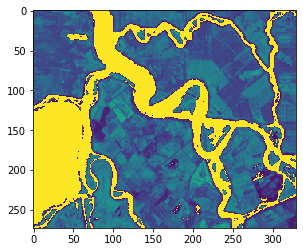

In [22]:
b5 = get_image([[38.097357, -121.638645], [38.022724, -121.527724]], datetime.now(), 5)
b4 = get_image([[38.097357, -121.638645], [38.022724, -121.527724]], datetime.now(), 4)

ndvi = np.clip((b5 - b4) / (b5 + b4 + 0.001), 0, 1)

plt.imshow(ndvi)
print(type(ndvi), ndvi.shape, ndvi.dtype, np.min(ndvi), np.max(ndvi), np.average(ndvi))
plt.show()

2

 EntityId: LC08_L1TP_116066_20180930_20181010_01_T1 

 Checking content:  

  Downloading: LC08_L1TP_116066_20180930_20181010_01_T1_B5.TIF

 EntityId: LC08_L1TP_115066_20190910_20190917_01_T1 

 Checking content:  

  Downloading: LC08_L1TP_115066_20190910_20190917_01_T1_B5.TIF
[116.008957, 116.639777, -8.746833, -8.283499]


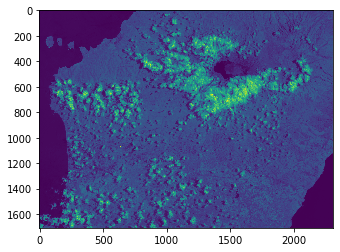

In [23]:
b2 = get_image([[-8.283499, 116.008957], [-8.746833, 116.639777]], datetime.now(), 5)

plt.imshow(b2)
plt.show()